# Bayesian Marketing Mix Models 



## Objective of this Notebook 

This notebook serves as a guide on how to build MM models in order to obtain contributions of the different channels (touchpoints) on product sales. This toy example includes relevant feature transformations as adstock (decay), seasonality, saturation, lags, etc. 

Likewise, it has been built with toy data which mimics real-life scenarios, but is not a full picture of the marketing spends a real product has during a year.

The basic application of these type of models uses a sophisticated Bayesian models using the famous [LightweightMMM](https://github.com/google/lightweight_mmm) library.

## About Bayesian Models and Probabilistic Programming. 

This excellent [tutorial](https://juanitorduz.github.io/intro_pymc3/) made by the developers of [PYMC](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) (one of the leading open-source Bayesian statistics libraries in Python), goes over the fundamentals of Bayesian Machine Learning and a few of its advantages over traditional (frequentist) approaches.


## About the data. 

We are using the same dataset as in the [mmx_linear_model_example](mmx_linear_model_example.ipynb), find more details there.

## 1. Imports and setup

# LightWeight MMX

Marketing Mix is much more advanced. It uses Bayesian models and it allows for seamless calculation of adstock, ROI and more. It also includes a powerful optimizer. It's a great starting point for advanced MMX models.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Import the relevant modules of the lightweight_mmm library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp


In [2]:
data_path = "../data/cough_and_cold_sales.csv"

# Define channels to use.
CHANNELS: list[str] = ['tv', 'social_media', 'congress', 'trade']
EXT_VARS: list[str] = ['flu_index', 'stringency_index'] 
# Define target variable.
TARGET = 'sales'
# Define weeks for testing period.
TEST_SIZE = 8
# Seed for reproducibility
SEED = 123456

# load data
df = pd.read_csv(data_path, sep= ";", parse_dates=["date"])
df.set_index('date', inplace=True)
# Lightweight wants the data in a different format

media_data = df[CHANNELS].values
extra_features = df[EXT_VARS].values
target = df[TARGET].values.reshape(1, -1)[0, : , ]
# We assign (arbitrarly in this example) a total cost per channel
costs = jnp.array(
    [
        350,  # TV cost in hundreds of thousands
        100,  # social media
        200,  # congress
        175,  # trade
    ]
)


In [3]:

# Split and scale data.
split_point = len(df) - TEST_SIZE
# Media data
media_data_train = media_data[: split_point, ...]
media_data_test = media_data[split_point: , ...]
# Extra features
extra_features_train = extra_features[: split_point , ...]
extra_features_test = extra_features[split_point: , ...]
# Target
target_train = target[: split_point]

Scaling is essential for many modelling problems and this one is no exception.

Lightweight MMM provides `CustomScaler` which behaves accordingly with sklearn scalers.

In this case, for the `cough_and_cold_sales.csv` the data is ALREADY scaled, so no need to re-escale it, however, for demonstration, we are going to scale the cost data as well. 

**__NOTE__**

---
In most cases you will need 3 or 4 scalers. One scaler for the media data, one for the target and one for costs. Optionally if you are adding extra features those might need an extra scaler. It is very important that you save and "carry with you" those scalers throughout your MMM journey as LighweightMMM will allow you to re-insert these scalers at different points to ensure everything is always in the correct scale and results. If some results don't make sense, it might be a scaling problem.

A few more details on CustomScaler usage:

This scaler can be used in two fashions for both the multiplication and division operation.

By specifying a value to use for the scaling operation.
By specifying an operation used at column level to calculate the value for the
actual scaling operation.

Eg. if one wants to scale the dataset by multiply by 100 you can directly pass multiply_by=100. Value can also be an array of an appropriate shape by which to divide or multiply the data. But if you want to multiply by the mean value of each column, then you can pass multiply_operation=jnp.mean (or any other operation desired).

Operation parameters have the upper hand in the cases where both values and operations are passed, values will be ignored in this case.

Consult the full class documentation if you still need to know more.

In this demo we divide the data on media, extra features and the target by their mean to ensure that the result has a mean of 1. This allows the model to be agnostic to the scale of the inputs (e.g. a user can use either the number of sales or the value of sales). The costs are not used in the model directly, they are only used to inform the prior distributions on the media variables (see the model documentation here). These costs have been scaled down by multiplying by 0.15 to reflect typical ranges in MMMs.

---

In [4]:
# Leaving commented examples of how the scalers for the other datasets will look. 

# media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
# extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
# target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

# media_data_train = media_scaler.fit_transform(media_data_train)
# extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
# target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

In [5]:
costs

Array([0.25454548, 0.07272728, 0.14545456, 0.12727274], dtype=float32)

# Data Quality (EDA)

In [6]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_data,
    target_data=target,
    cost_data=costs,
    extra_features_data=extra_features
)

In [7]:
correlations[0].round(2)

,feature_0,feature_1,feature_2,feature_3,extra_feature_0,extra_feature_1,target
feature_0,1.00,0.39,0.18,0.79,0.52,-0.68,0.70
feature_1,0.39,1.00,0.30,0.45,0.27,-0.05,0.28
feature_2,0.18,0.30,1.00,0.38,0.20,-0.22,0.30
feature_3,0.79,0.45,0.38,1.00,0.41,-0.65,0.71
extra_feature_0,0.52,0.27,0.20,0.41,1.00,-0.47,0.40
extra_feature_1,-0.68,-0.05,-0.22,-0.65,-0.47,1.00,-0.72
target,0.70,0.28,0.30,0.71,0.40,-0.72,1.00


In [8]:
# We should always aim for values under 3 ideally, but surely under 5!
variance_inflation_factors

,geo_0
feature_0,3.727141
feature_1,1.611609
feature_2,1.290635
feature_3,3.577824
extra_feature_0,1.490821
extra_feature_1,2.555454


For any analysis that aims to analyse feature importance, it's primordial to check for correlation in the covariates (covariance) as it can obfuscate or obscure the true relationship between the independent variables and your target variable. Tests like VIF (Variance Inflation Factor) can help you spot covariance issues. In case you assess that the variables are heavily correlated, it's important to either merge them into one feature, or find a way to "break" the correlation and isolate their effect.

# Training the model

The model executes multiple simulations using [Markov Chain Monte Carlo](https://num.pyro.ai/en/stable/mcmc.html) simulations, which require a "warmup" to facilitate convergence. 

In [9]:
mmm = lightweight_mmm.LightweightMMM(model_name="adstock")

number_warmup=1_000
number_samples=1_000

In [10]:

# For replicability in terms of random number generation in sampling
# reuse the same seed for different trainings.
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    extra_features=extra_features_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    seed=SEED
)

/Users/kdlx593/miniconda3/envs/mmx/lib/python3.12/site-packages/lightweight_mmm/lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [00:15<00:00, 126.44it/s, 255 steps of size 1.13e-02. acc. prob=0.94]


In [11]:
mmm.print_summary()



                            mean       std    median      5.0%     95.0%     n_eff     r_hat
coef_extra_features[0]     -0.11      0.04     -0.10     -0.19     -0.04   1137.83      1.00
coef_extra_features[1]     -0.29      0.04     -0.28     -0.36     -0.22    782.72      1.00
         coef_media[0]      0.29      0.06      0.29      0.19      0.41    596.05      1.00
         coef_media[1]      0.03      0.02      0.02      0.00      0.06   1368.42      1.00
         coef_media[2]      0.06      0.05      0.05      0.00      0.12    598.19      1.01
         coef_media[3]      0.19      0.06      0.19      0.09      0.30    586.50      1.00
         coef_trend[0]      0.01      0.00      0.01      0.00      0.01    181.09      1.01
            expo_trend      0.75      0.14      0.74      0.55      0.98     79.55      1.02
           exponent[0]      0.90      0.08      0.92      0.78      1.00   1840.33      1.00
           exponent[1]      0.90      0.08      0.92      0.78      1

Ideally we would never allow an RHat value of above 1.1, and we should aim for 0 divergences. If divergences are present, they invalidate our model!! We need to analyse what could cause them with some diagnonstics

## Bayesian Diagnostics

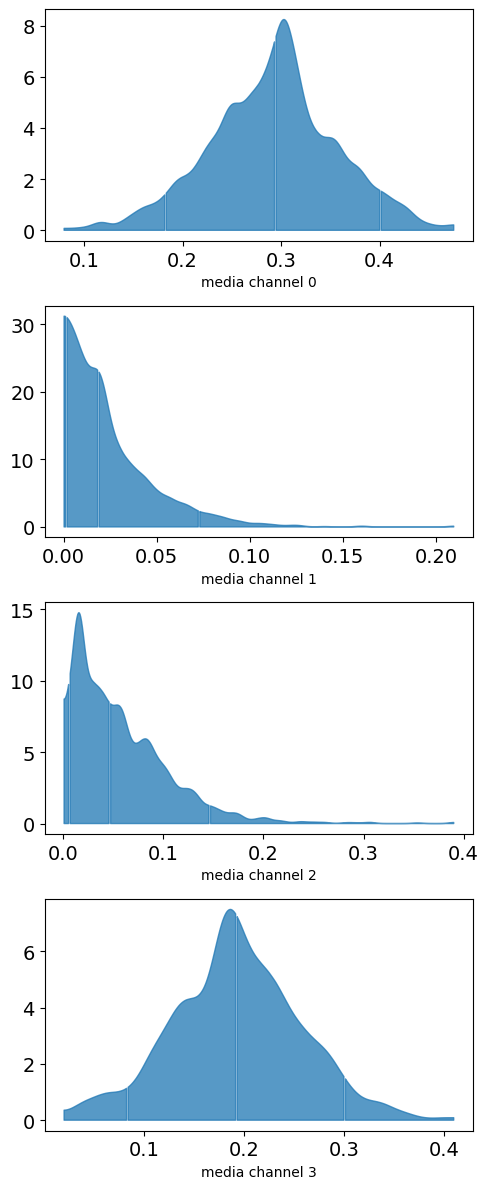

In [12]:
plot.plot_media_channel_posteriors(media_mix_model=mmm)


In [13]:
### Posteriors vs Priors

/var/folders/gm/82lk2qqj3737203ydr7y53r80000gq/T/ipykernel_60726/2787768002.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  plot.plot_prior_and_posterior(media_mix_model=mmm)


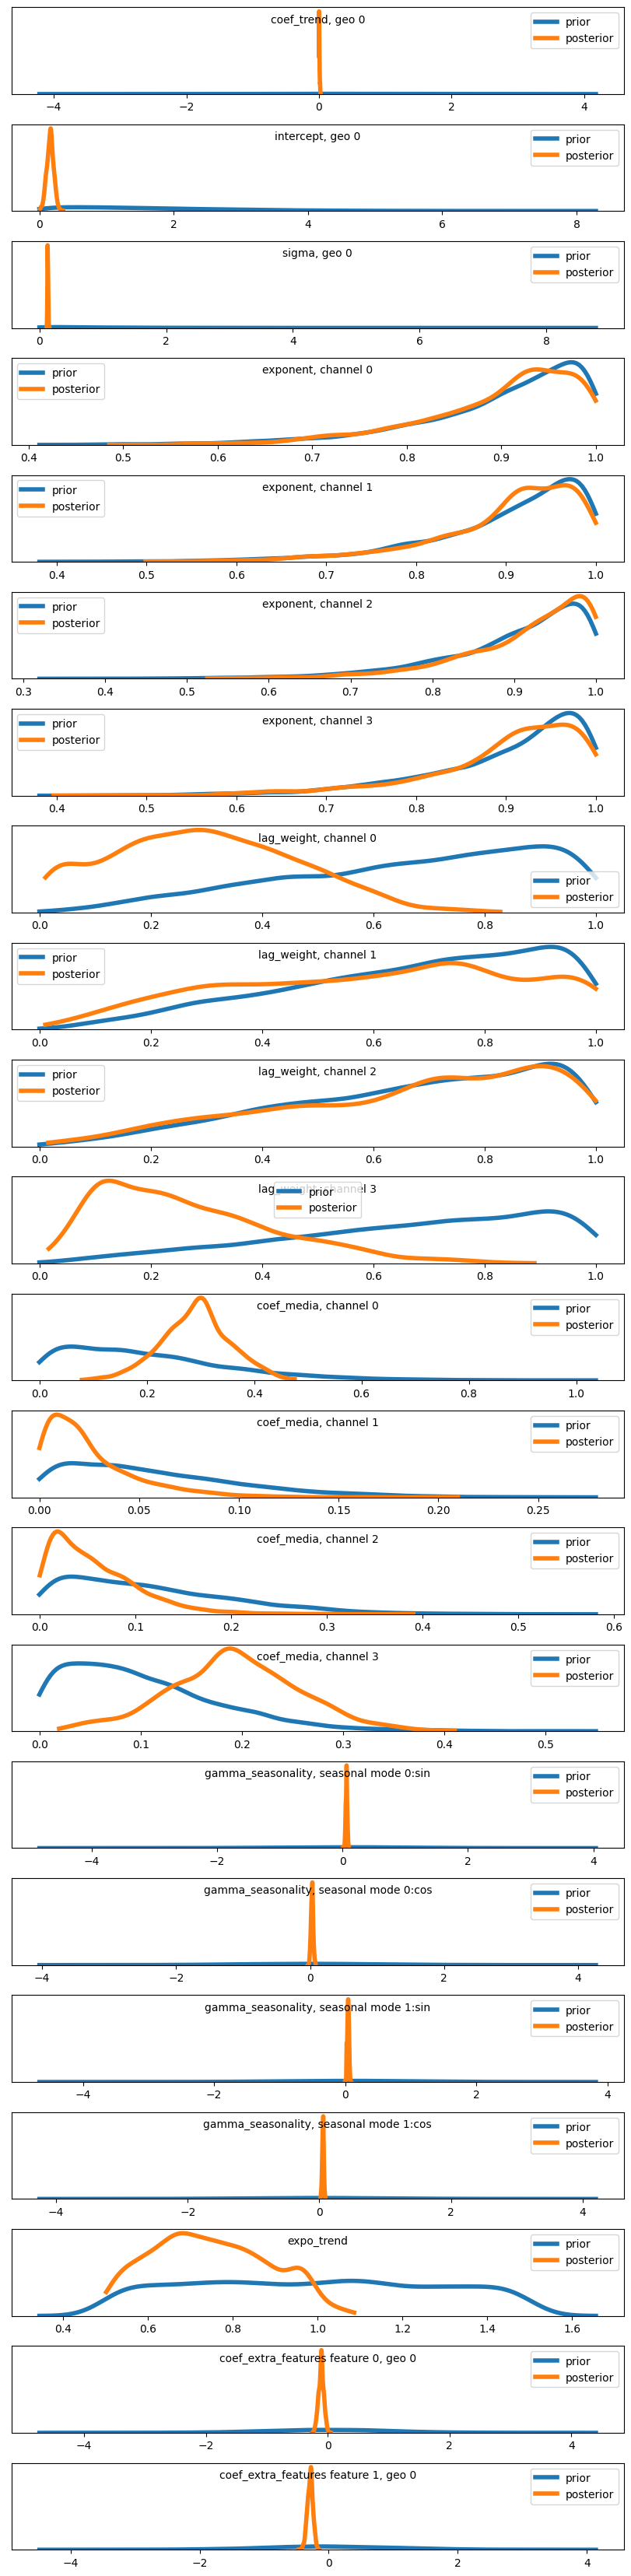

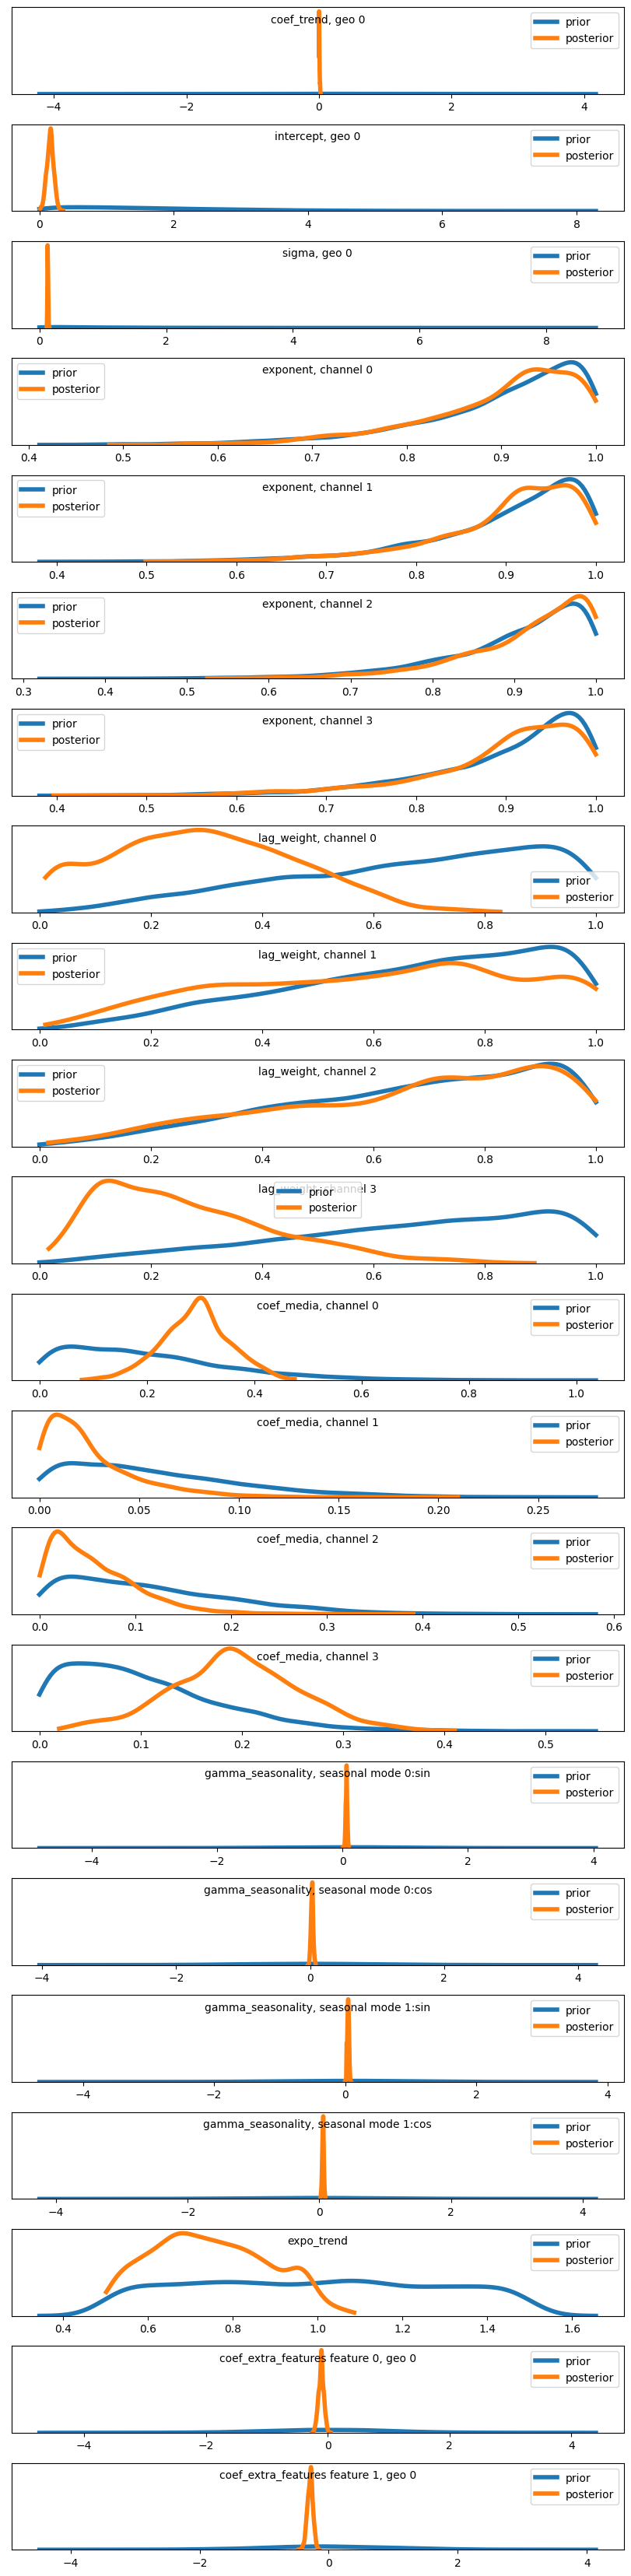

In [14]:
plot.plot_prior_and_posterior(media_mix_model=mmm)


If the organge line is close to the blue one, it means our "priors" are informative and well selected. If not, then we probably passed on uninformative or wrong priors. We can modify them and re-run the experiment if needed

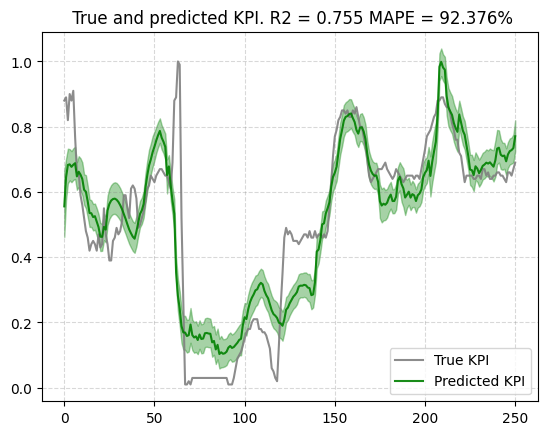

In [15]:

# We fit the model and check its performance.
plot.plot_model_fit(mmm)

In [16]:

# We have to scale the test media data if we have not done so before.
new_predictions = mmm.predict(
    media=media_data_test,
    extra_features=extra_features_test,
    seed=SEED
)
new_predictions.shape

(2000, 8)

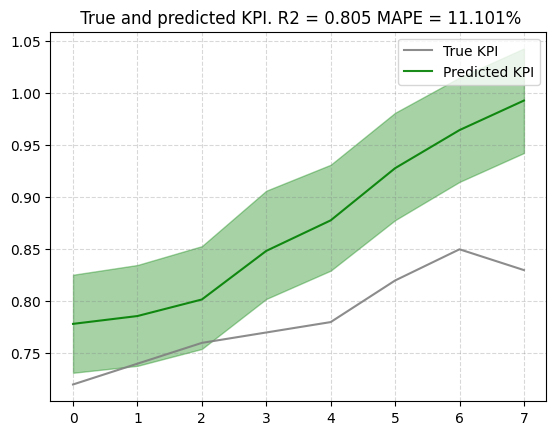

In [17]:

plot.plot_out_of_sample_model_fit(
    out_of_sample_predictions=new_predictions,
    out_of_sample_target=target[split_point:]
)


# Media insights

In [18]:
media_contribution, roi_hat = mmm.get_posterior_metrics(cost_scaler=cost_scaler)


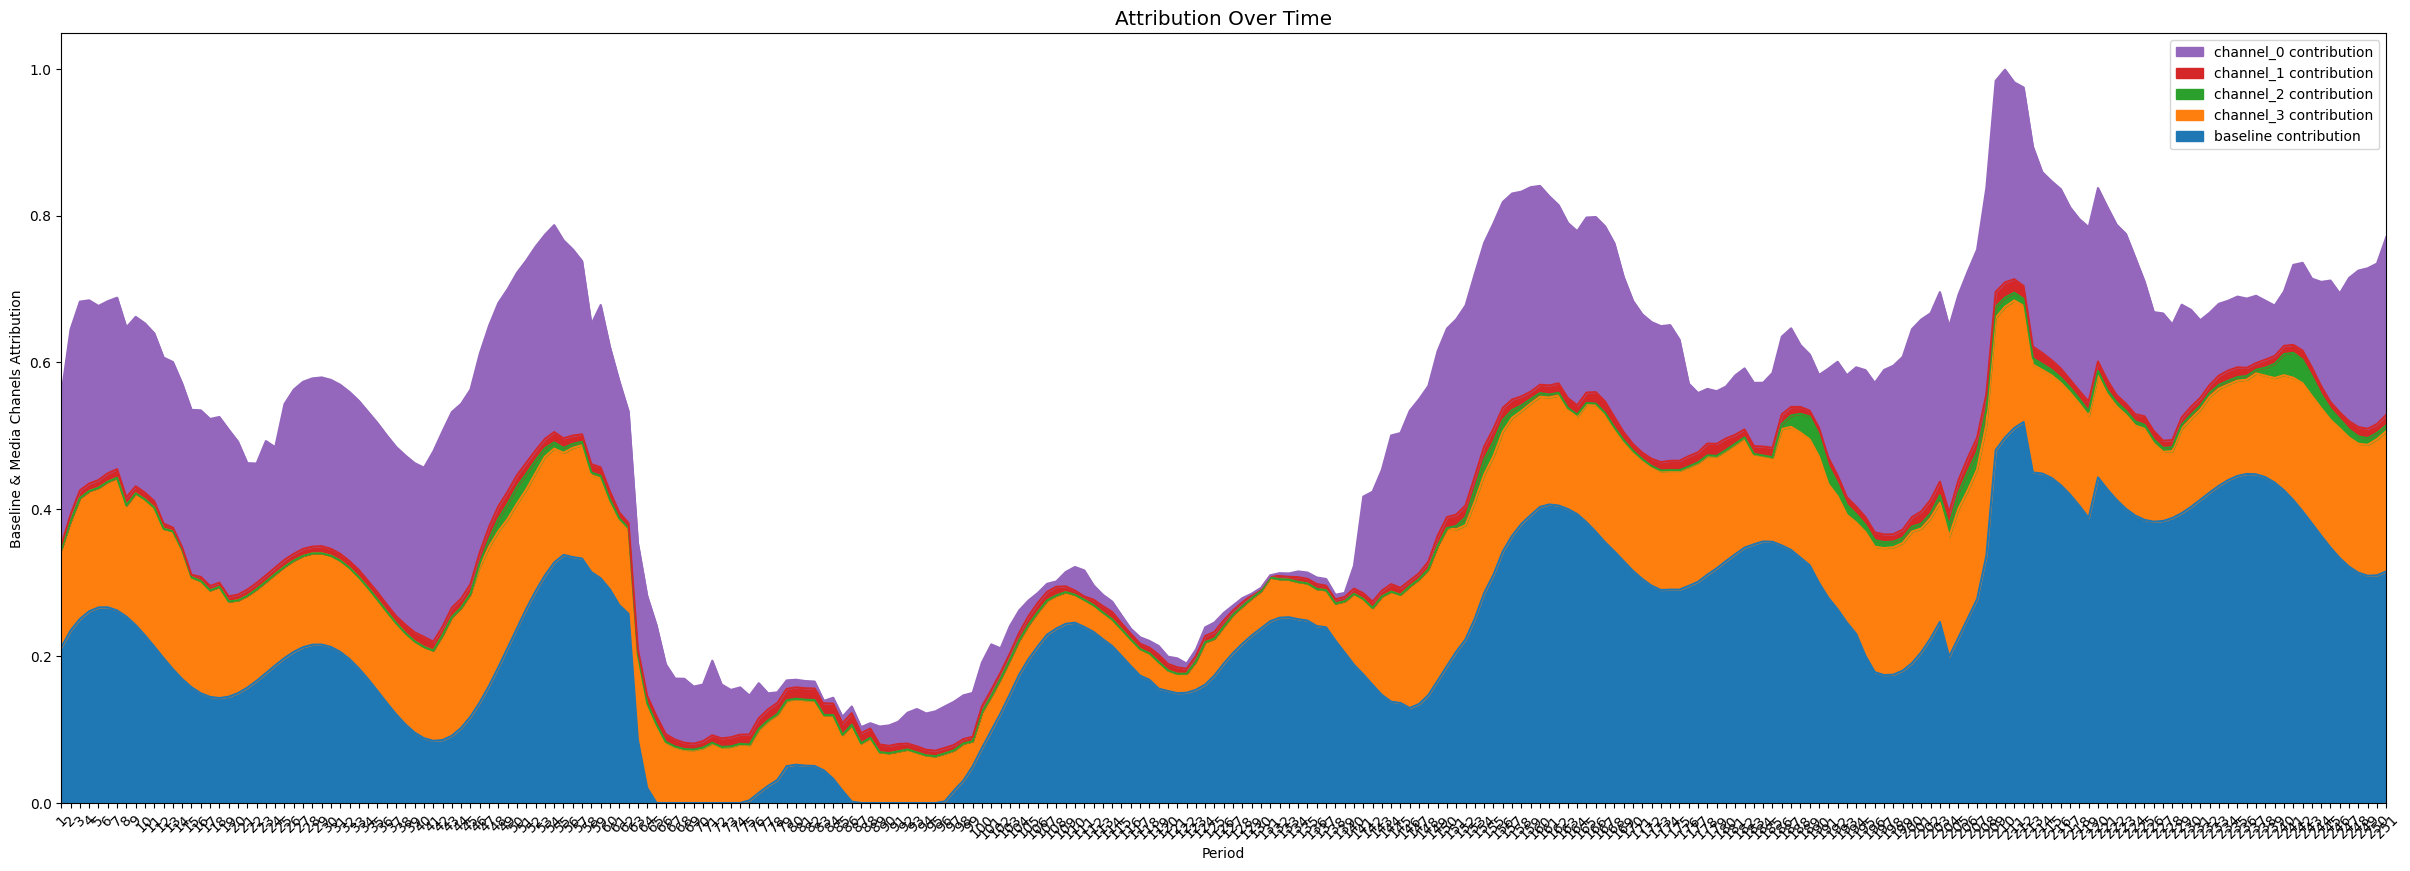

In [19]:
plot.plot_media_baseline_contribution_area_plot(
    media_mix_model=mmm,
    fig_size=(30,10)
)

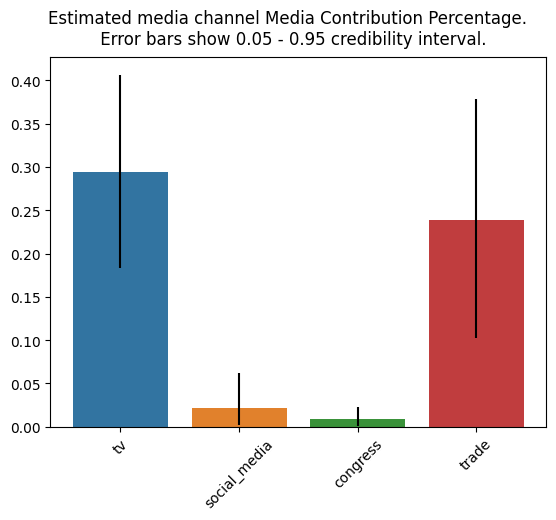

In [20]:
plot.plot_bars_media_metrics(
    metric=media_contribution,
    metric_name="Media Contribution Percentage",
    channel_names=CHANNELS
)


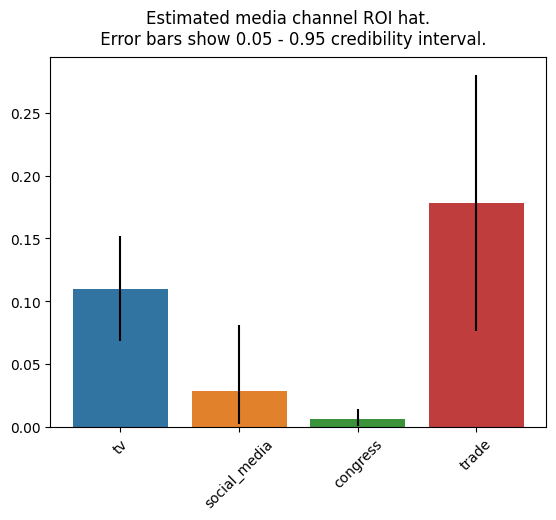

In [21]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=CHANNELS)


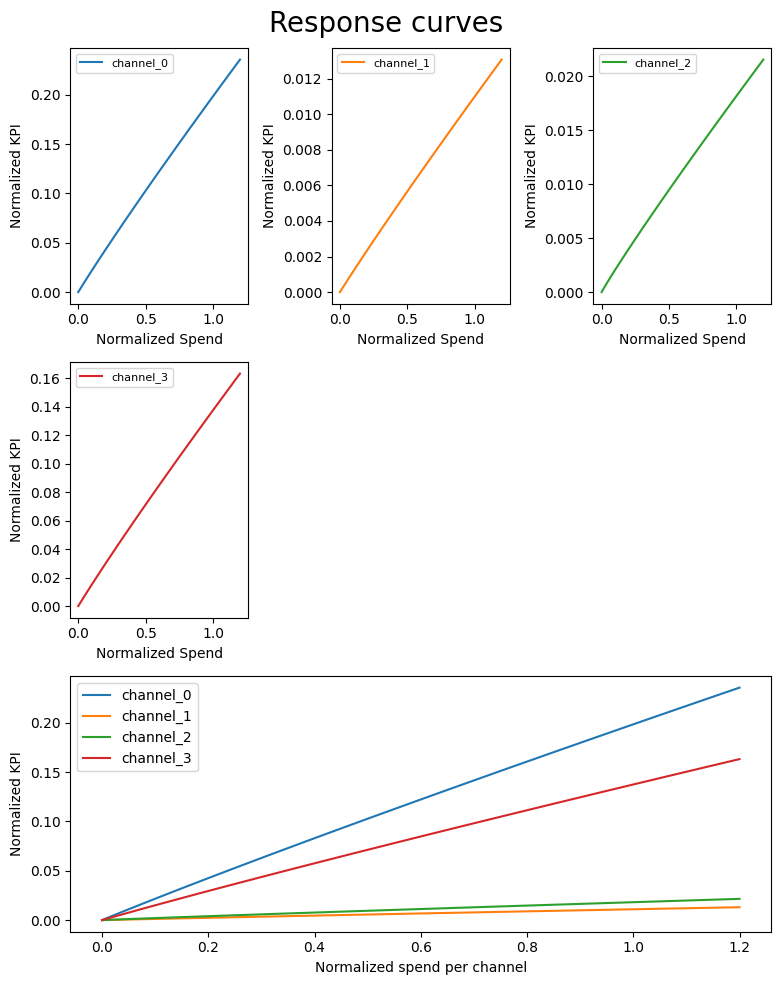

In [22]:
# KPI == incremental sales contribution
plot.plot_response_curves(
    media_mix_model=mmm, seed=SEED,
)

# Optimization

In [23]:
prices = jnp.ones(mmm.n_media_channels)
n_time_periods = TEST_SIZE
budget = jnp.sum(jnp.dot(prices, media_data.mean(axis=0))) * n_time_periods
     

In [24]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=mmm,
    extra_features=extra_features_test[:n_time_periods],
    budget=budget,
    prices=prices,
    seed=SEED
)
     

Optimization terminated successfully    (Exit mode 0)
            Current function value: -5.929112252203945
            Iterations: 4
            Function evaluations: 36
            Gradient evaluations: 4


In [25]:

# Obtain the optimal weekly allocation.
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([4.83251   , 2.81753   , 0.49670118, 5.3077765 ], dtype=float32)

In [26]:
# similar renormalization to get previous budget allocation
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([4.1303716 , 3.6122363 , 0.63679963, 5.07511   ], dtype=float32)

In [27]:

# Both numbers should be almost equal
budget, jnp.sum(solution.x * prices)

(Array(13.454517, dtype=float32), Array(13.454517, dtype=float32))

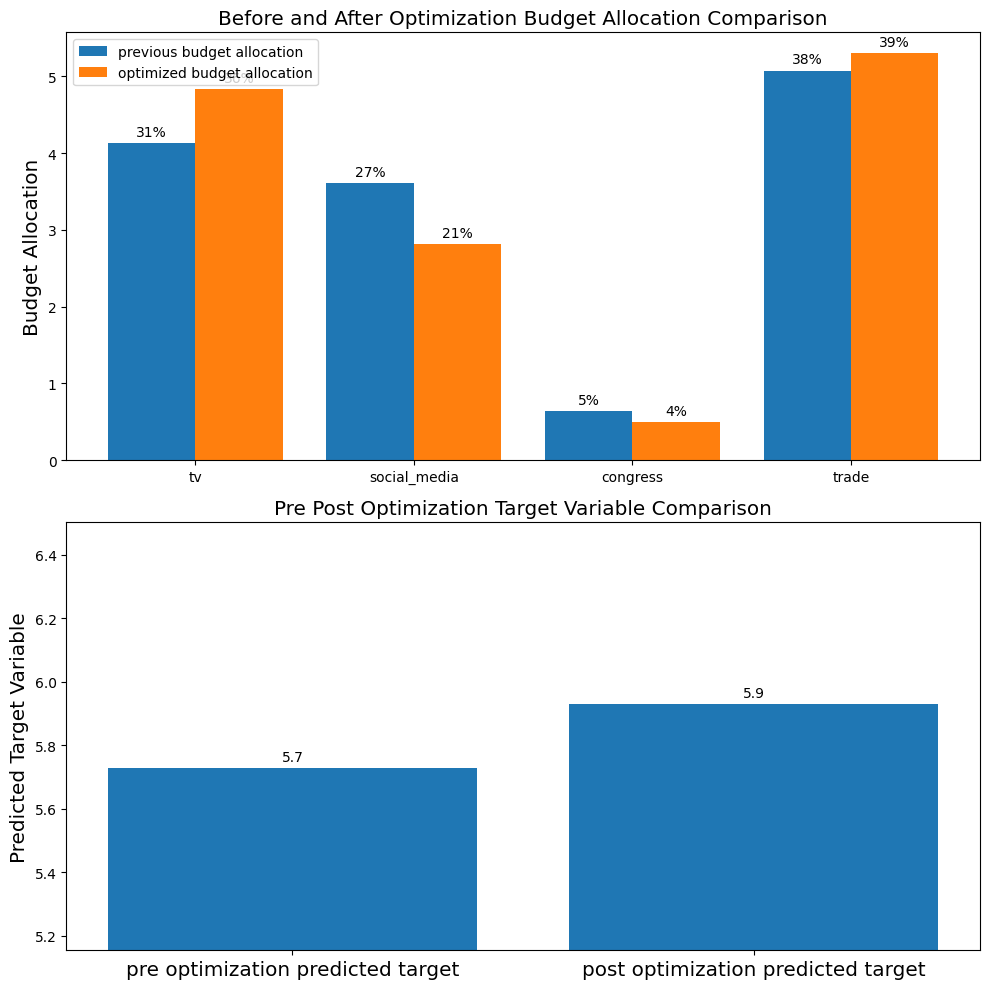

In [28]:

# Plot out pre post optimization budget allocation and predicted target variable comparison.
plot.plot_pre_post_budget_allocation_comparison(
    media_mix_model=mmm, 
    kpi_with_optim=solution['fun'], 
    kpi_without_optim=kpi_without_optim,
    optimal_buget_allocation=optimal_buget_allocation, 
    previous_budget_allocation=previous_budget_allocation, 
    figure_size=(10,10),
    channel_names=CHANNELS
)


## Discussion

- How can we improve the accuracy?
    - Seasonality
    - adding flags
- What can you say about the recommendations?